https://github.com/NanoComp/meep/blob/master/python/examples/straight-waveguide.ipynb  

https://stackoverflow.com/questions/29454002/filenotfounderror-errno-2-no-such-file-or-directory-ffmpeg


In [10]:
import math
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rc
rc('text', usetex=False)
#plt.rcParams['font.family'] = 'Times New Roman'#使用するフォント
#plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')

In [3]:
def phc_trans(PhC = True, lengthPhC = 100, decay_check=0, T_decay=500):
    """
    <変数の説明>
    PhC...PhC(フォトニック決勝)を配置するかどうか。Falseで直線導波路
    lengthPhC...PhC導波方向の長さ
    widthPhC...PhC垂直方向の幅。PMLと被ってるので適当。
    ConnectionWaveguide...PhCに接続するSi導波路(棒の部分)の長さ
    wgi...導波路の幅を調整する。1で丸穴一個分空いてることを意味する。0.7とかにすると狭くなってバンドの形が変わる、っていうのはDaii君の研究とも絡む。
    r...穴の半径。ふつうはa/4くらい。meepだと格子定数は1で固定だから、格子定数との比を入力すればOK
    n_eff...屈折率。2次元だと2.5~2.7くらいにしておくと3次元のSi系(n_Si=3.48)と結果が近くなる。違う材料を使うときは要調整、通常はdefaultで大丈夫。
    fcen...入力光（ガウシアンビーム）の中心周波数。知りたいPhCバンドの周波数近くに設定する
    df...入力光（ガウシアンビーム）の半値幅（で合ってる？）
    nfreq...入力光（ガウシアンビーム）のきめ細かさ
    resolution...メッシュの細かさ。2^nにすると計算が軽くなるらしい。
    T_dacay...反復計算数。小さいと誤差が増え、大きいと時間がかかる。sim.run(until_after_sources=...)で計算時間を見積もってから変えるとよさそう
    decay_check...解の収束をどこで判定するか、位置を指定。defaultでOK

    <備考>
    ・meepでは格子定数aはパラメータに含まれないので設定不要
    　誘電体を使うときは入力するらしい（スケール依存性が出るから）
    ・THzやnmは使用せず、すべて規格化周波数で入力する (周波数はωa/2πcで直す)
    """
    ##### setting of parameters #####
    a = 1 # CADに移行しやすいように予め設定しておく
    widthPhC = 10
    ConnectionWaveguide = 5
    wgi = 1/2 #/np.sqrt(3)/2
    whetero = 1/np.sqrt(3)/4
    r = 1/4
    d_0 = 0.85*a
    yshift = -np.sqrt(3)/4*a #1/(np.sqrt(3)) #+ 1/6*np.sqrt(3)/2*d_0
    n_eff = 2.6
    fcen = 0.3 
    df = 0.2
    nfreq = 5000 # number of frequencies at which to compute flux
    resolution = 16

    connect = 0
    #####
    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC
    Nx = int(lengthPhC)
    Ny = int(widthPhC)
    eps = n_eff**2

    # settings of imaginary part
    normalized_frequency = 0.3
    extinction_coefficient = 0.

    ##### settings of geometry #####
    # initialization
    cell = mp.Vector3(length,width*np.sqrt(3),0)

    # Si waveguide
    waveguide = mp.Block(mp.Vector3(mp.inf,wgi*np.sqrt(3),mp.inf),
                            center=mp.Vector3(),
                            material=mp.Medium(epsilon=eps))
    geometry = [waveguide]

    # PhC
    if PhC:
        # triangle
        tri_u = [
                mp.Vector3(-np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3),
                mp.Vector3( np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3),
                mp.Vector3(            0,   1)*d_0/np.sqrt(3),
                ]
        tri_d = [
                mp.Vector3(-np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3)*(-1),
                mp.Vector3( np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3)*(-1),
                mp.Vector3(            0,   1)*d_0/np.sqrt(3)*(-1),
                ]

        # slab
        blk_above = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                                center=mp.Vector3(0, widthPhC*np.sqrt(3)/2 + 0*(yshift + 1/(2*np.sqrt(3))), 0),
                                material=mp.Medium(epsilon=eps, D_conductivity=0*2*np.pi*normalized_frequency*extinction_coefficient / eps))
        geometry.append(blk_above)
        blk_below = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                                center=mp.Vector3(0,-widthPhC*np.sqrt(3)/2 + 0*(yshift + 1/(2*np.sqrt(3))), 0),
                                material=mp.Medium(epsilon=eps, D_conductivity=2*np.pi*normalized_frequency*extinction_coefficient / eps))
        geometry.append(blk_below)
        
        # arrange air-holes
        for j in range(Ny):
            for i in range(Nx+1):
                shift_y = np.sqrt(3)
                geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift + 1/(np.sqrt(3)) + shift_y*(j+1/2))))                
                geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift -(1/(np.sqrt(3)) + shift_y*(j+1/2)))))            
                geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(i-Nx/2, yshift +  1/(np.sqrt(3)) + shift_y*j )))

            if j == 0:
                for i in range(connect,Nx+1-connect):
                    geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-Nx/2, yshift - (1/(np.sqrt(3)) + shift_y*j))))
            else:
                for i in range(Nx+1):
                    geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-Nx/2, yshift - (1/(np.sqrt(3)) + shift_y*j))))
                    
        for i in range(1,Nx+1):
            geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift - (1/(np.sqrt(3)) + shift_y*(-1/2)))))
        #geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(1, 0)))


                #geometry.append(mp.Cylinder(r, center=mp.Vector3(i-N/2,-wgi*np.sqrt(3)/2)))

    # Gaussian
    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                            component=mp.Hz,
                            center=mp.Vector3(-length/2 +1,0),
                            size=mp.Vector3(0,wgi*np.sqrt(3)))
                ]

    # PML
    pml_layers = [mp.PML(1.0)]

    # z-symmetry (上下対称なら計算が軽くなる。対称性が無いなら消す)
    #sym = [mp.Mirror(mp.Y, phase=-1)]
    

    ####
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=sym,
                        resolution=resolution)

    #tran_in = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2-1,0),size=mp.Vector3(0, 2*wgi))
    tran_out = mp.FluxRegion(center=mp.Vector3(length/2-3/2,0),size=mp.Vector3(0, 2*wgi))
    #trans_in = sim.add_flux(fcen, df, nfreq, tran_in)
    trans_out = sim.add_flux(fcen, df, nfreq, tran_out)

    # show geometry
    %matplotlib inline
    f = plt.figure(dpi=500, figsize=(8,16))
    sim.plot2D(ax=f.gca())
    plt.show()    

    #sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(decay_check), 1e-3))
    sim.run(until=T_decay)

    freqs = mp.get_flux_freqs(trans_out)
    #psd_in = mp.get_fluxes(trans_in)
    psd_out = mp.get_fluxes(trans_out)

    return freqs, psd_out


-----------
Initializing structure...
time for choose_chunkdivision = 0.000566959 s
Working in 2D dimensions.
Computational cell is 30 x 17.3125 x 0 with resolution 16
     block, center = (0,0,0)
          size (1e+20,0.866025,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
time for set_epsilon = 0.327631 s
-----------
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


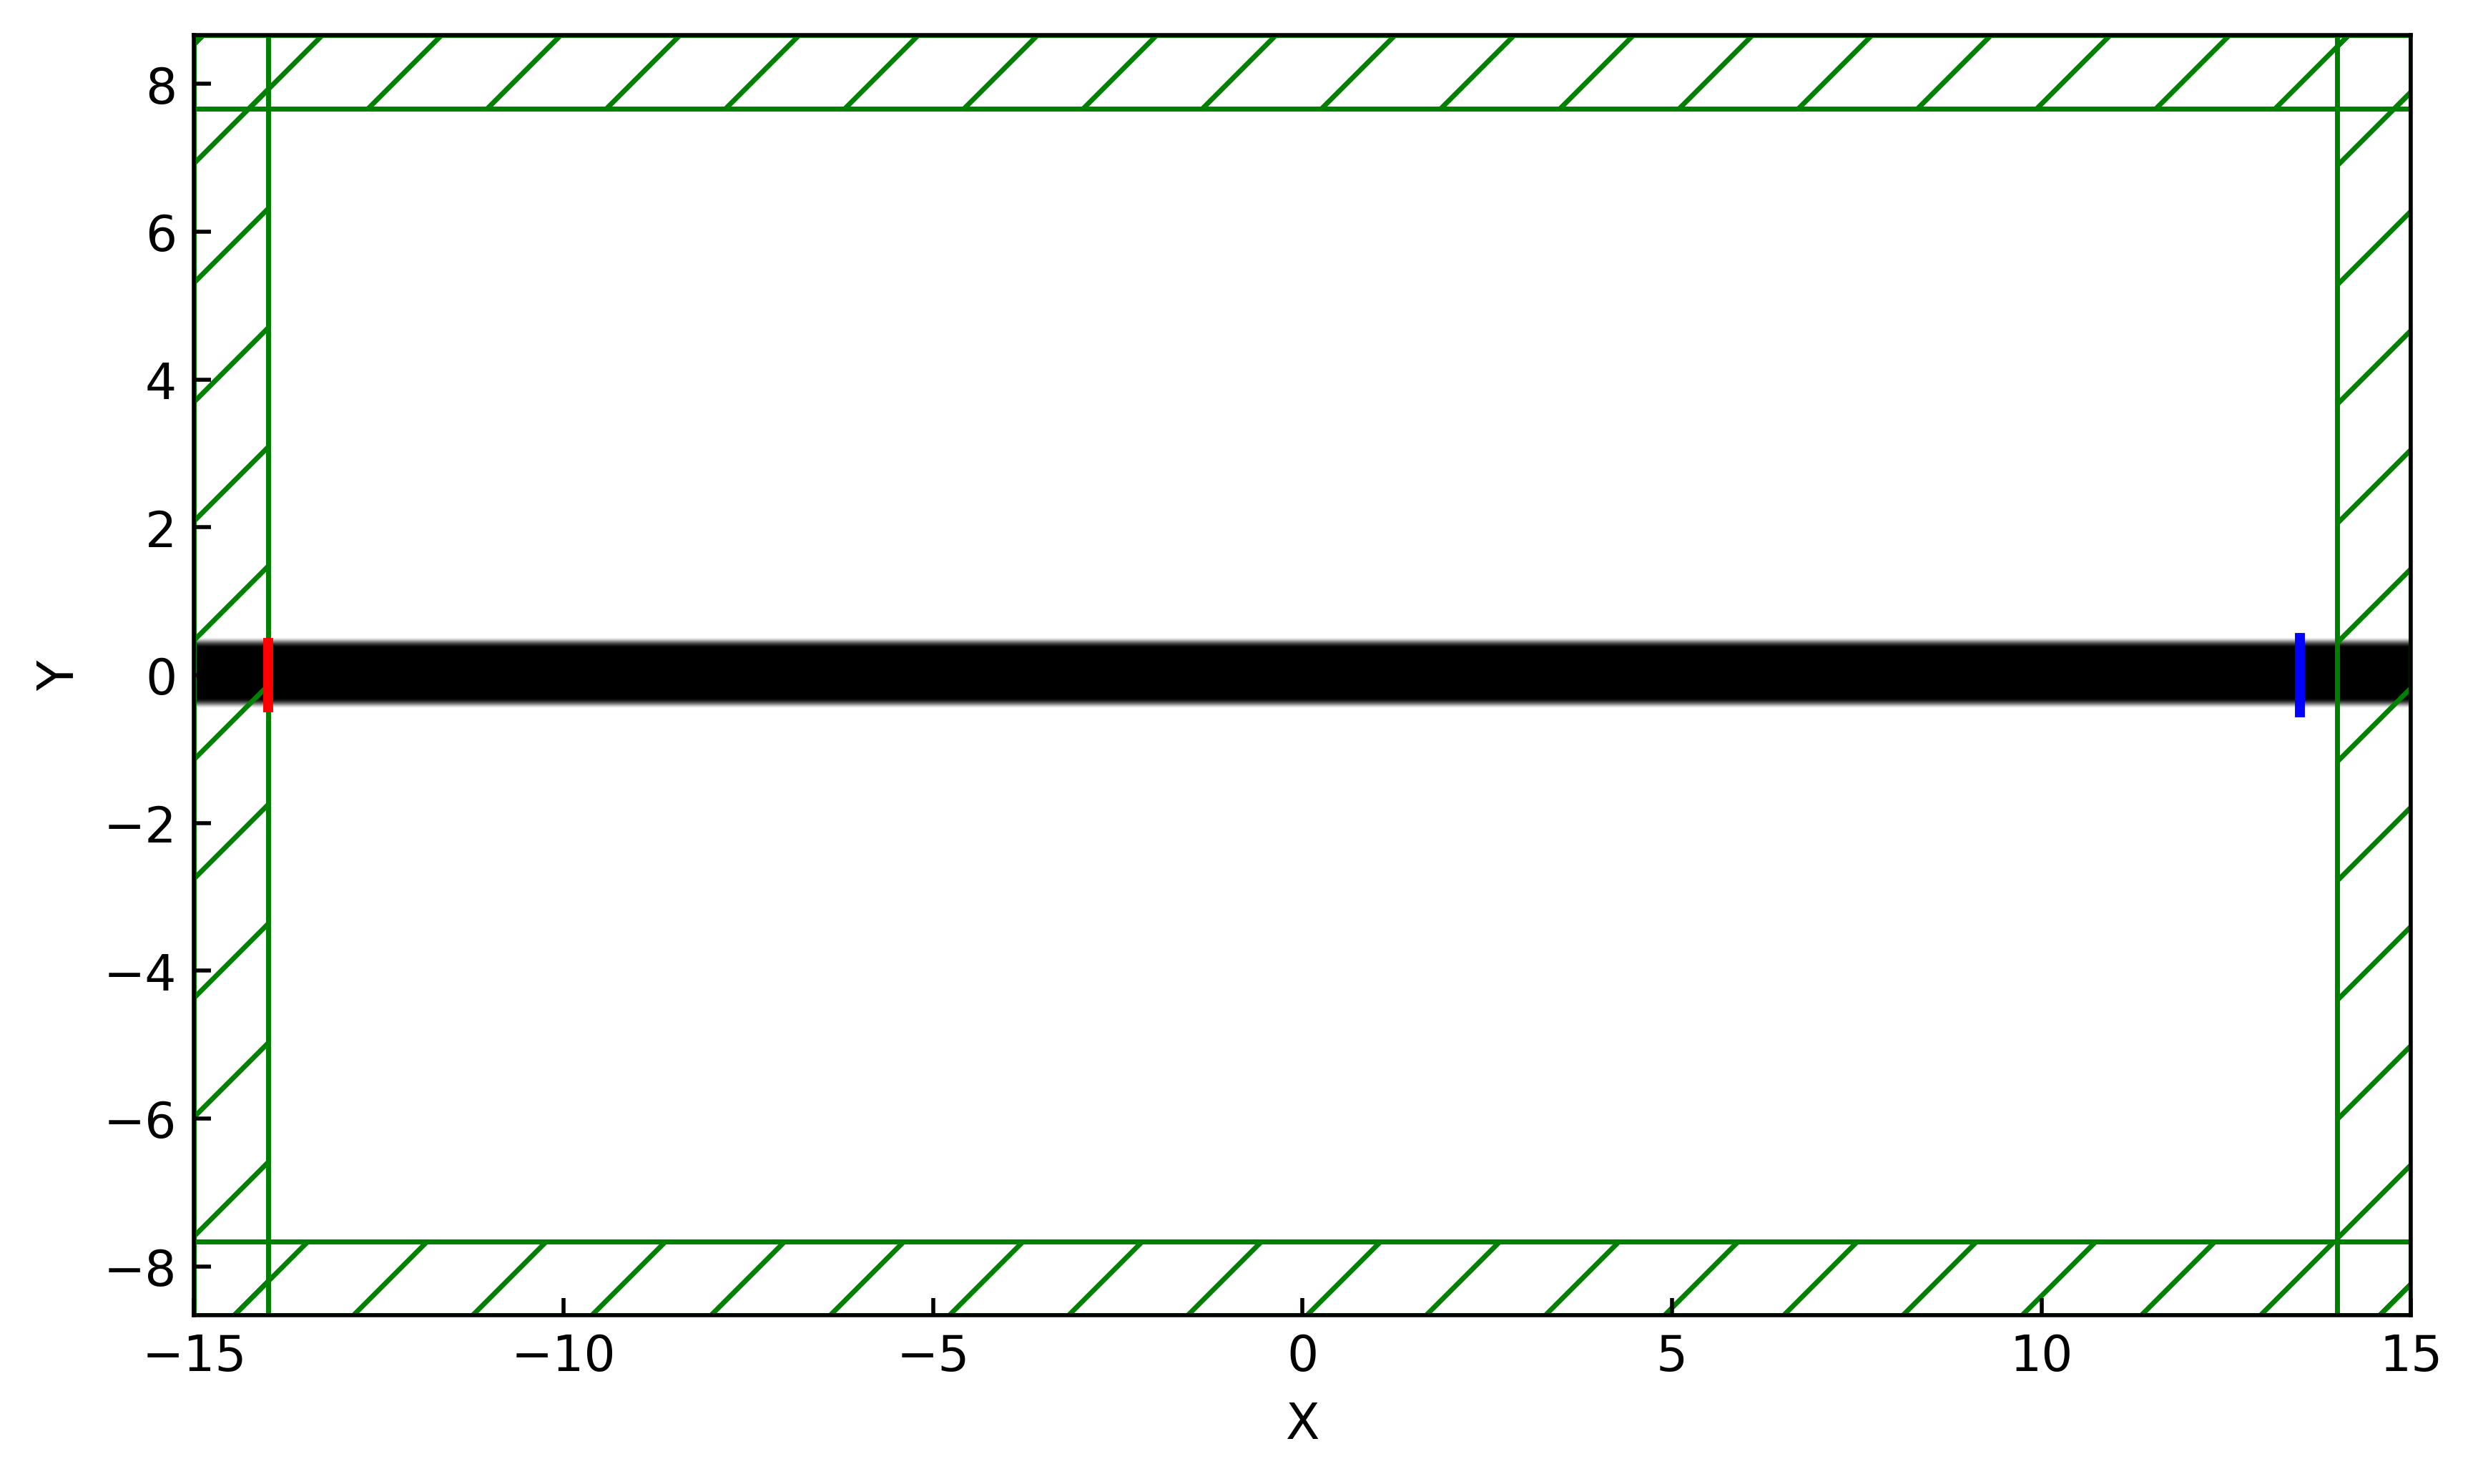

FloatProgress(value=0.0, description='0% done ', max=500.0)

Meep progress: 31.09375/500.0 = 6.2% done in 4.0s, 60.3s to go
on time step 997 (time=31.1562), 0.00401256 s/step
Meep progress: 67.1875/500.0 = 13.4% done in 8.0s, 51.6s to go
on time step 2152 (time=67.25), 0.00346444 s/step
Meep progress: 106.65625/500.0 = 21.3% done in 12.0s, 44.3s to go
on time step 3416 (time=106.75), 0.00316585 s/step
Meep progress: 148.53125/500.0 = 29.7% done in 16.0s, 37.9s to go
on time step 4756 (time=148.625), 0.00298565 s/step
Meep progress: 188.03125/500.0 = 37.6% done in 20.0s, 33.2s to go
on time step 6021 (time=188.156), 0.00316567 s/step
Meep progress: 219.78125/500.0 = 44.0% done in 24.0s, 30.6s to go
on time step 7035 (time=219.844), 0.00394877 s/step
Meep progress: 260.03125/500.0 = 52.0% done in 28.0s, 25.9s to go
on time step 8330 (time=260.312), 0.0030898 s/step
Meep progress: 302.96875/500.0 = 60.6% done in 32.0s, 20.8s to go
on time step 9702 (time=303.188), 0.00291765 s/step
Meep progress: 343.625/500.0 = 68.7% done in 36.0s, 16.4s to go
on 

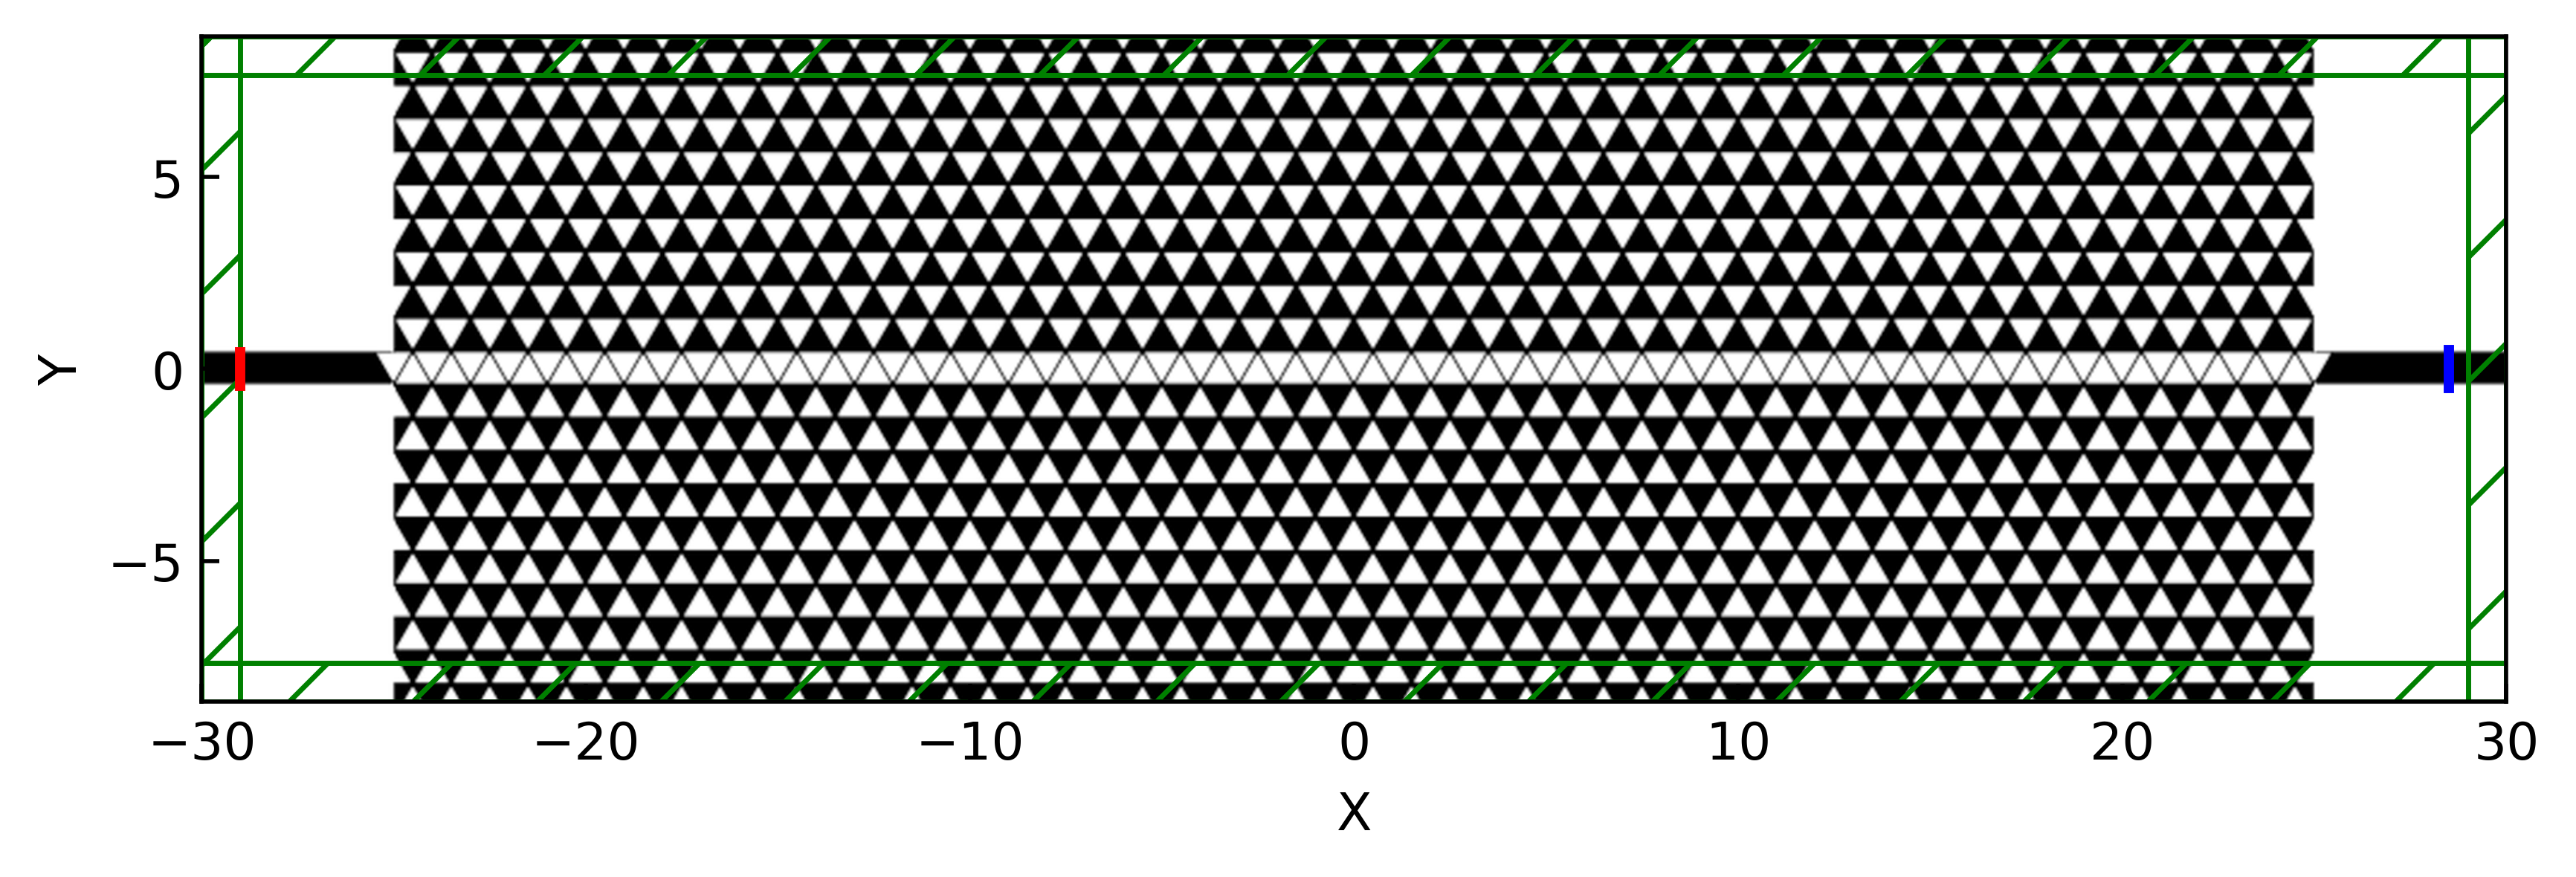

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 16.21875/1000.0 = 1.6% done in 4.0s, 242.7s to go
on time step 520 (time=16.25), 0.00771539 s/step
Meep progress: 34.46875/1000.0 = 3.4% done in 8.0s, 224.4s to go
on time step 1105 (time=34.5312), 0.00684173 s/step
Meep progress: 47.53125/1000.0 = 4.8% done in 12.0s, 240.8s to go
on time step 1523 (time=47.5938), 0.00957279 s/step
Meep progress: 65.15625/1000.0 = 6.5% done in 16.0s, 229.8s to go
on time step 2088 (time=65.25), 0.00708255 s/step
Meep progress: 87.09375/1000.0 = 8.7% done in 20.0s, 209.9s to go
on time step 2790 (time=87.1875), 0.00570263 s/step
Meep progress: 109.75/1000.0 = 11.0% done in 24.0s, 194.9s to go
on time step 3514 (time=109.812), 0.00552983 s/step
Meep progress: 129.78125/1000.0 = 13.0% done in 28.0s, 188.0s to go
on time step 4156 (time=129.875), 0.00623874 s/step
Meep progress: 150.40625/1000.0 = 15.0% done in 32.0s, 181.0s to go
on time step 4817 (time=150.531), 0.00605508 s/step
Meep progress: 170.0/1000.0 = 17.0% done in 36.0s, 176.0s to

In [4]:
freqs_wo, psd_out_wo = phc_trans(PhC = False, lengthPhC = 20, decay_check=10, T_decay=500)
freqs_w,  psd_out_w  = phc_trans(PhC = True, lengthPhC = 50, decay_check=20, T_decay=1000)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


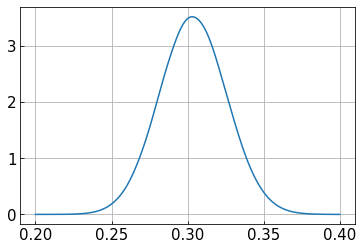

In [11]:
plt.plot(freqs_wo,psd_out_wo)
plt.grid(True)

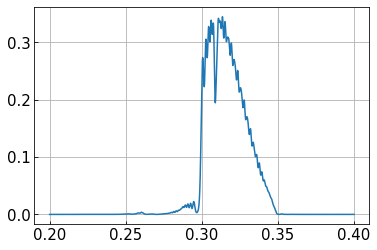

In [12]:
plt.plot(freqs_w,psd_out_w)
plt.grid(True)

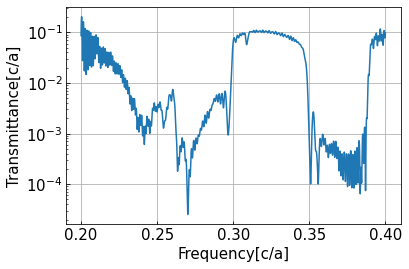

In [13]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

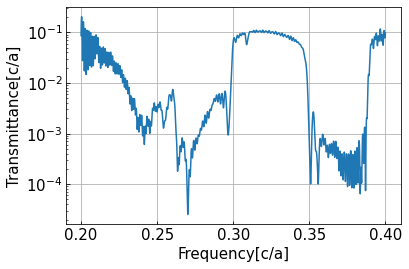

In [14]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

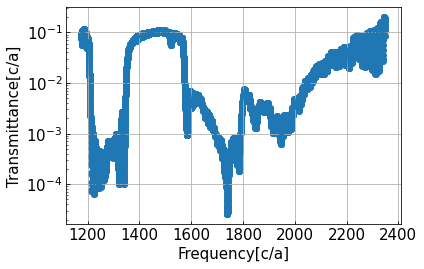

In [15]:
a = 470
c_const = 299792458

freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
#plt.xlim([0.28,0.30])
plt.yscale('log')
plt.grid(True)

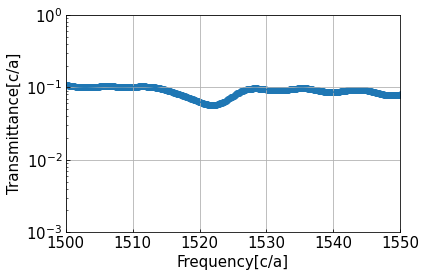

In [19]:
freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.xlim([1500,1550])
plt.yscale('log')
plt.ylim([1e-3,1e-0])
plt.grid(True)

In [15]:
df = pd.DataFrame()
df["wavelength"] = freqs
df["transmittance"] = np.array(psd_out_w)/np.array(psd_out_wo)
df.to_csv("210111_waveguide_VPhCtriangle_bearded_adiabatic_transmittance_d085_km005.csv")


In [16]:
df

,wavelength,transmittance
0,2350.000000,0.035522
1,2345.300000,0.033173
2,2340.618762,0.030877
3,2335.956175,0.028562
4,2331.312127,0.026239
...,...,...
495,1179.728370,0.019919
496,1178.542714,0.020704
497,1177.359438,0.021691
498,1176.178536,0.023108
